<center>
    <br />
    <h1>An introduction to Deep Learning with Pytorch</h1>
    <br /><br />
   Yifei Huang
    <br /><br />
    MAFS6010U
    <br /><br />
    HKUST
</center>

## <font color=red>Prerequires</font> 

- Materials available on  <a href="https://piazza.com/ust.hk/spring2019/mafs6010u/resources">Piazza</a>
    
- Require a Python distribution with scientific packages (NumPy, SciPy, Scikit-Learn, Pandas, <font color=red>Pytorch</font>)

- One can refer to this <a href="https://pytorch.org/">Link</a> to install Pytorch

- One can refer to this <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py">Link</a> to learn basic operation in Pytorch

# Outline

* Preprocess data with Pytorch Dataloader
* RNN and CNN
* Generative Adversarial Network
* Reinforcement Learning

### Load some packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import os
import argparse
import pandas as pd
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = '1' # indecate which gpu you want to use

try:
    from mpl_finance import candlestick_ohlc
except ImportError:
    ! pip install mpl_finance
    from mpl_finance import candlestick_ohlc
    
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('ggplot')

### Loading external data with pandas

In [2]:
data = pd.read_csv('./okex_future_BTC_USD_this_week_1H.csv',
                   parse_dates=['candle_begin_time'])

In [3]:
data.head()

,candle_begin_time,open,high,low,close,volume
0,2018-05-15 00:00:00,8674.33,8761.76,8663.17,8696.66,172152.0
1,2018-05-15 01:00:00,8694.66,8728.17,8662.17,8701.85,122668.0
2,2018-05-15 02:00:00,8699.98,8741.04,8642.36,8673.34,181228.0
3,2018-05-15 03:00:00,8673.19,8717.70,8638.95,8707.10,193166.0
4,2018-05-15 04:00:00,8710.92,8737.36,8684.20,8699.16,155912.0


### Visualization

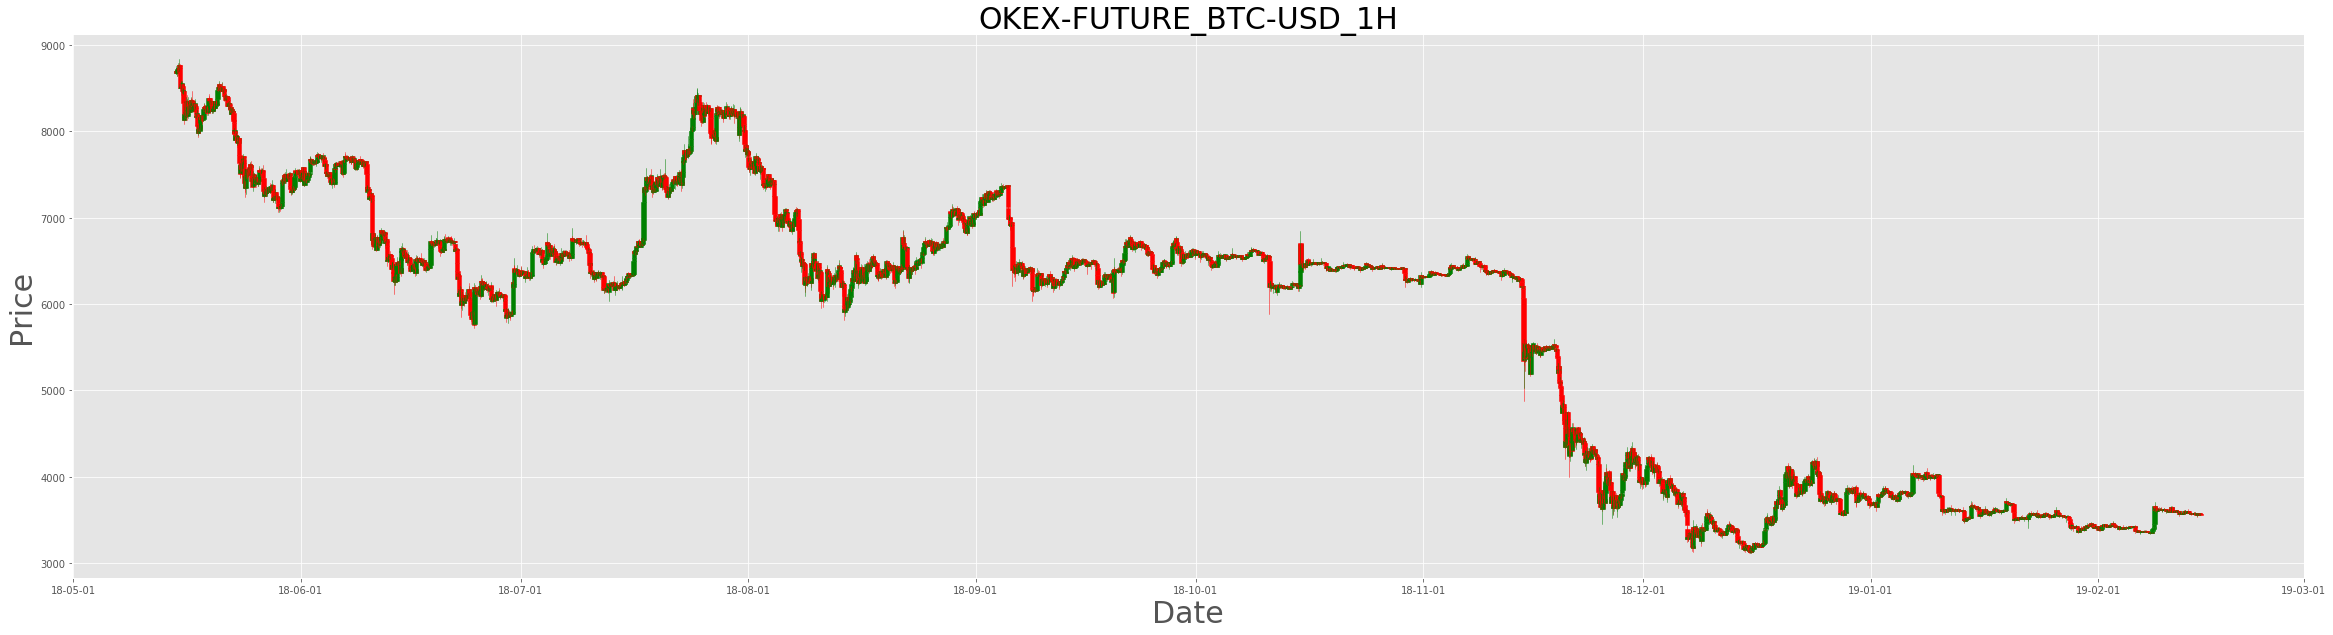

In [4]:
data['timestamp'] = data.candle_begin_time.apply(mdates.date2num)
fig, ax = plt.subplots(1, 1, figsize=(40, 10))
plt.title('OKEX-FUTURE_BTC-USD_1H', fontsize=30)
candlestick_ohlc(ax,
                 data[['timestamp', 'open', 'high', 'low', 'close']].values,
                 width=.6,
                 colorup='g',
                 alpha=1)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
ax.set_ylabel('Price', fontdict={'size': 30})
ax.set_xlabel('Date', fontdict={'size': 30})
data = data.drop(['timestamp'], axis=1)

In [5]:
parse = argparse.ArgumentParser(description='Tutorial2MAFS6010U')

parse.add_argument('--input_length', default=12, type=int)
parse.add_argument('--input_dim', default=5, type=int)
parse.add_argument('--training_ratio', default=0.8, type=float)
parse.add_argument('--batch_size', default=64, type=int)
parse.add_argument('--hidden_dim', default=128, type=int)
parse.add_argument('--rnn_layers', default=1, type=int)
parse.add_argument('--lr', default=1e-4, type=float)
parse.add_argument('--epochs', default=10, type=int)

parse.add_argument('--cnn_kernels',default=[2,3,4],type=list)
parse.add_argument('--cnn_channels',default=64,type=int)

config, _ = parse.parse_known_args()

# First Part

## <font color=red>RNN and CNN</font>
### We want to build a Recurrent neural network and Convolutional neural network  to predict the next close price

### <font color=red>RNN</font>:
* Navie RNN
* <font color=red>GRU</font>
* LSTM

![](https://drive.google.com/uc?id=1B9zjuzsSfSjxI_qL7ahaCMmibSSC0EHi)

First of all, we need to write a dataloader to load our data based on our requirements

In [6]:
class FinDataset(Dataset):
    def __init__(self, input_length=12, training_ratio=.8, training=True):
        data = pd.read_csv('./okex_future_BTC_USD_this_week_1H.csv',
                           parse_dates=['candle_begin_time'])
        data.index = data['candle_begin_time']
        data = data.drop(['candle_begin_time'], axis=1)
        training_size = int(len(data) * training_ratio)
        self.data = data[:training_size] if training else data[training_size:]
        self.input_length = input_length

    def __getitem__(self, idx):
        # input is the previous state
        # label is the next close price
        input_seq = self.data.values[idx:idx + self.input_length]
        label = self.data.close[idx + self.input_length]
        mean = np.mean(input_seq, axis=0, keepdims=True)
        std = np.std(input_seq, axis=0, keepdims=True)
        
        # do scaling for input
        input_seq = (input_seq - mean) / (std + 1e-8)

        close_price = self.data.close[idx:idx + self.input_length]
        self.mean = close_price.mean()
        self.std = close_price.std()
        
        # do scaling for label
        label = (label - self.mean) / (self.std + 1e-8)
        return input_seq, label

    def __len__(self):
        return len(self.data) - self.input_length

In [7]:
training_dataset = FinDataset(input_length=12,
                              training_ratio=.8,
                              training=True)
val_dataset = FinDataset(input_length=12, training_ratio=.8, training=False)

In [8]:
print(f'Training size: {len(training_dataset)}, Val size: {len(val_dataset)}')

Training size: 5287, Val size: 1313


In [9]:
training_dataset[0]

(array([[-1.37962864,  0.18147287, -0.59518499, -0.80949459,  0.40760911],
        [-0.56938742, -0.83929303, -0.63166397, -0.61047626, -0.66016787],
        [-0.35736168, -0.44818684, -1.3543126 , -1.70373495,  0.6034531 ],
        [-1.42506273, -1.15746567, -1.47870593, -0.40915714,  0.86105397],
        [ 0.07864614, -0.56001829,  0.171968  , -0.71362835,  0.0571787 ],
        [-0.45659929, -0.17590156,  0.18728917, -0.01342127, -0.25320251],
        [ 0.05074802,  0.91810179,  0.92854209,  0.53723445,  0.2370548 ],
        [ 0.845446  ,  0.01463736,  1.11312574,  0.35777284, -1.17381598],
        [ 0.63979697, -0.85053696, -1.14820636, -0.00498504,  0.04125397],
        [ 0.23407854, -0.63963742,  0.40871659, -0.32671217, -1.22931518],
        [-0.14971993,  2.51200389,  0.60825663,  1.98366439,  2.37972958],
        [ 2.48904403,  1.04482385,  1.79017564,  1.71293811, -1.27083169]]),
 1.4061453421112702)

Usually we need to use DataLoader in Pytorch to load our data, because it is faster than our implementation

In [10]:
def get_loader(config):
    training_dataset = FinDataset(input_length=config.input_length,
                                  training_ratio=config.training_ratio,
                                  training=True)
    val_dataset = FinDataset(input_length=config.input_length,
                             training_ratio=config.training_ratio,
                             training=False)
    
    # one can tune the batch_size, not too small, not too large
    # here we define our dataloader to load training data and validation data
    # usually we need to shuffle the training data to increase generalization but not shuffle the val data
    # pin_memory should always set to be True to reduce the CPU memory use
    training_loader = DataLoader(training_dataset,
                                 config.batch_size,
                                 shuffle=True,
                                 num_workers=4,
                                 pin_memory=True)
    val_loader = DataLoader(val_dataset,
                            config.batch_size,
                            shuffle=False,
                            num_workers=4,
                            pin_memory=True)

    return {'train': training_loader, 'val': val_loader}

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, rnn_layers=1):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # define our recurrent neural network
        self.gru = nn.GRU(input_dim, hidden_dim, rnn_layers, batch_first=True)

        # define our regressor because our problem is a regression problem
        self.regressor = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                       nn.ReLU(inplace=True), nn.Dropout(.5),
                                       nn.Linear(hidden_dim // 2, 1))

        # here do the initialization for recurrent neural network
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            if 'bias' in name:
                bias_length = param.size()[0]
                start, end = bias_length // 4, bias_length // 2
                param.data[start:end].fill_(1.)

    def forward(self, s):
        # s: torch.tensor [batch_size, t, m]
        # where t is the sequence length, m is the feature length (how many features you have)
        output, hidden = self.gru(s)
        
        # output: torch.tensor [batch_size, t, hidden_dim]
        # usually we use the last output i.e. output[:, -1, :] as the later input
        output = self.regressor(output[:, -1, :])
        return output

Epoch: [0/10]
iters: [0/83], training_loss: 4.6170
iters: [80/83], training_loss: 4.1754
val_loss: 4.9485
Epoch: [1/10]
iters: [0/83], training_loss: 4.2196
iters: [80/83], training_loss: 3.8386
val_loss: 4.5632
Epoch: [2/10]
iters: [0/83], training_loss: 2.0318
iters: [80/83], training_loss: 3.3538
val_loss: 4.1762
Epoch: [3/10]
iters: [0/83], training_loss: 9.0688
iters: [80/83], training_loss: 3.1163
val_loss: 4.0551
Epoch: [4/10]
iters: [0/83], training_loss: 1.7701
iters: [80/83], training_loss: 3.0344
val_loss: 3.9876
Epoch: [5/10]
iters: [0/83], training_loss: 3.3667
iters: [80/83], training_loss: 2.9157
val_loss: 3.9482
Epoch: [6/10]
iters: [0/83], training_loss: 0.7015
iters: [80/83], training_loss: 2.9102
val_loss: 3.9085
Epoch: [7/10]
iters: [0/83], training_loss: 0.9521
iters: [80/83], training_loss: 2.6907
val_loss: 3.8947
Epoch: [8/10]
iters: [0/83], training_loss: 2.2297
iters: [80/83], training_loss: 2.8626
val_loss: 3.8831
Epoch: [9/10]
iters: [0/83], training_loss: 2.

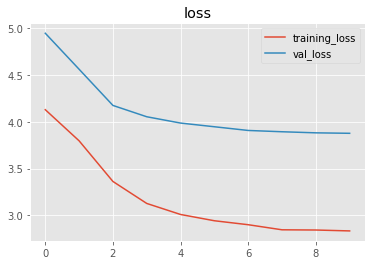

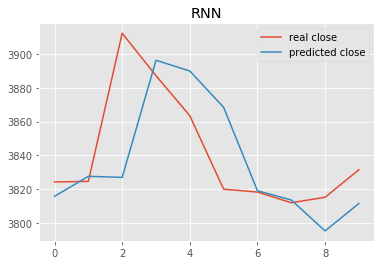

In [12]:
use_gpu = torch.cuda.is_available()
loaders = get_loader(config)

# initial our model
model = RNNModel(config.input_dim, config.hidden_dim, config.rnn_layers)
if use_gpu:
    model = model.cuda()

# define our loss
criterion = nn.MSELoss()
# define our optimizer, usually we use adam or sgd
# you should tune the lr usually from 0.1 to 1e-4
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=5e-7)

losses = {'train': [], 'val': []}
for epoch in range(config.epochs):
    print(f'Epoch: [{epoch}/{config.epochs}]')
    training_size, val_size = 0, 0
    training_loss, val_loss = 0, 0
    
    # before training, do not forget to set the model to be training mode
    model.train()
    
    # use loader to load our training data
    for i, (inputs, labels) in enumerate(loaders['train']):
        
        # float our inputs and labels
        inputs, labels = inputs.float(), labels.float()
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, ), labels)

        # after getting the loss, we need to do gradient desent by the following three lines
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_size += inputs.size()[0]
        training_loss = training_loss + loss.item() * inputs.size()[0]

        if i % 80 == 0:
            print(
                f"iters: [{i}/{len(loaders['train'])}], training_loss: {training_loss / training_size:.4f}"
            )

    losses['train'].append(training_loss / training_size)
    
    # before do validation, do not forget to set the model to be eval mode,
    # because it will affect batch_normalization and dropout layers
    model.eval()
    
    # and set torch.no_grad() to save GPU memory and be faster
    with torch.no_grad():
        
        # load our validation data
        for i, (inputs, labels) in enumerate(loaders['val']):
            inputs, labels = inputs.float(), labels.float()
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, ), labels)

            val_size += inputs.size()[0]
            val_loss += loss.item() * inputs.size()[0]

        losses['val'].append(val_loss / val_size)
        print(f"val_loss: {val_loss / val_size:.4f}")

# plot the training loss and val loss
plt.title('loss')
plt.plot(losses['train'], label='training_loss')
plt.plot(losses['val'], label='val_loss')
plt.legend()
plt.show()

# test our model on new data (here we simple use the validation data)
close_real = []
close_predict = []
for i in range(10):
    val_input, label = val_dataset[i]
    close_real.append(label * (val_dataset.std + 1e-8) + val_dataset.mean)
    val_input = torch.tensor(val_input).float().unsqueeze(0)
    if use_gpu:
        val_input = val_input.cuda()
    val_output = model(val_input)
    close_predict.append(val_output.item() * (val_dataset.std + 1e-8) +
                         val_dataset.mean)

plt.title('RNN')
plt.plot(close_real, label='real close')
plt.plot(close_predict, label='predicted close')
plt.legend()
plt.show()

## <font color=red>Further Improvement</font>
* Adjust learning rate during epochs, eg, step wise or cosine decay
* Use different inilization
* Clip gradient norm of parameters in case of gradient blow up
* Add more layers or use bidirection to enlarge model
* More data
* ...

<font color=red>For more tricks on RNN, you can refer this [tricks](https://danijar.com/tips-for-training-recurrent-neural-networks/)</font>

### <font color=red>CNN</font> (Time Series):
* <font color=red>Text CNN</font>

![](https://drive.google.com/uc?id=1GdNE4-llPnsDeCXp5cRHPZjZQWziiPLb)

In [13]:
class TextCNN(nn.Module):
    def __init__(self, input_dim, kernels=[2, 3, 4], channels=64):
        super(TextCNN, self).__init__()
        self.input_dim = input_dim
        self.dropout = nn.Dropout(.5)
        self.kernels = kernels
        self.channels = channels

        # here we define our cnn layers
        self.convs = self._make_conv_layers(1, self.channels, self.kernels)

        hidden_dim = self.channels * len(self.kernels)
        self.regressor = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                       nn.ReLU(inplace=True), nn.Dropout(.5),
                                       nn.Linear(hidden_dim // 2, 1))

    def forward(self, s):
        conv_feats = [
            conv(s.unsqueeze(1)).squeeze(3) for conv in self.convs
        ]
        conv_feats_max = torch.cat(
            [torch.max(feats, dim=2)[0] for feats in conv_feats], dim=1)

        output = self.regressor(conv_feats_max)
        return output

    def _make_conv_layers(self, input_channel, channels, kernels):
        convs = []
        for kernel in kernels:
            convs.append(
                nn.Sequential(
                    nn.Conv2d(input_channel,
                              channels, (kernel, self.input_dim),
                              stride=1), nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True)))
        return nn.ModuleList(convs)

Epoch: [0/10]
iters: [0/83], training_loss: 2.8204
iters: [80/83], training_loss: 4.1512
val_loss: 4.9487
Epoch: [1/10]
iters: [0/83], training_loss: 19.0332
iters: [80/83], training_loss: 3.8837
val_loss: 4.7732
Epoch: [2/10]
iters: [0/83], training_loss: 2.3307
iters: [80/83], training_loss: 3.7391
val_loss: 4.6696
Epoch: [3/10]
iters: [0/83], training_loss: 3.1343
iters: [80/83], training_loss: 3.6378
val_loss: 4.6036
Epoch: [4/10]
iters: [0/83], training_loss: 7.6225
iters: [80/83], training_loss: 3.4913
val_loss: 4.5464
Epoch: [5/10]
iters: [0/83], training_loss: 1.6343
iters: [80/83], training_loss: 3.4901
val_loss: 4.4952
Epoch: [6/10]
iters: [0/83], training_loss: 0.7859
iters: [80/83], training_loss: 3.4487
val_loss: 4.4516
Epoch: [7/10]
iters: [0/83], training_loss: 1.6998
iters: [80/83], training_loss: 3.3861
val_loss: 4.4020
Epoch: [8/10]
iters: [0/83], training_loss: 1.9916
iters: [80/83], training_loss: 3.3331
val_loss: 4.3623
Epoch: [9/10]
iters: [0/83], training_loss: 3

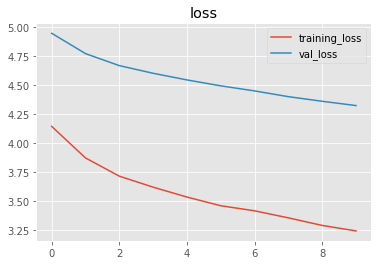

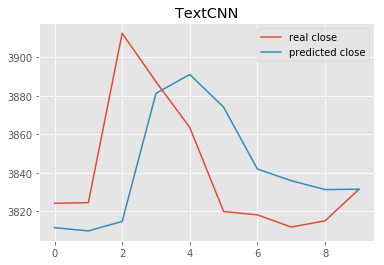

In [14]:
use_gpu = torch.cuda.is_available()
loaders = get_loader(config)
model = TextCNN(config.input_dim, config.cnn_kernels, config.cnn_channels)
if use_gpu:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=5e-7)

losses = {'train': [], 'val': []}
for epoch in range(config.epochs):
    print(f'Epoch: [{epoch}/{config.epochs}]')
    training_size, val_size = 0, 0
    training_loss, val_loss = 0, 0

    model.train()
    for i, (inputs, labels) in enumerate(loaders['train']):
        inputs, labels = inputs.float(), labels.float()
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, ), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_size += inputs.size()[0]
        training_loss = training_loss + loss.item() * inputs.size()[0]

        if i % 80 == 0:
            print(
                f"iters: [{i}/{len(loaders['train'])}], training_loss: {training_loss / training_size:.4f}"
            )
    losses['train'].append(training_loss / training_size)

    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders['val']):
            inputs, labels = inputs.float(), labels.float()
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs.float())
            loss = criterion(outputs.view(-1, ), labels.float())

            val_size += inputs.size()[0]
            val_loss += loss.item() * inputs.size()[0]

        losses['val'].append(val_loss / val_size)
        print(f"val_loss: {losses['val'][-1]:.4f}")

plt.title('loss')
plt.plot(losses['train'], label='training_loss')
plt.plot(losses['val'], label='val_loss')
plt.legend()
plt.show()

close_real = []
close_predict = []
for i in range(10):
    val_input, label = val_dataset[i]
    close_real.append(label * (val_dataset.std + 1e-8) + val_dataset.mean)
    val_input = torch.tensor(val_input).float().unsqueeze(0)
    if use_gpu:
        val_input = val_input.cuda()
    val_output = model(val_input)
    close_predict.append(val_output.item() * (val_dataset.std + 1e-8) +
                         val_dataset.mean)

plt.title('TextCNN')
plt.plot(close_real, label='real close')
plt.plot(close_predict, label='predicted close')
plt.legend()
plt.show()

## <font color=red>Further Improvement</font>
* Adjust learning rate during epochs, eg, step wise or cosine decay
* Use different inilization
* More cnn layers
* Use more kernels and larger channels
* Adjust dropout rate
* More data
* ...

<font color=red>For more tricks on CNN, you can refer this [tricks](https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8)</font>

# Second Part

## <font color=red>GAN</font>
### We want to build a GAN which can generate the next price based on previous market
* <font color=red>Generator</font>: RNN used to generate the next price
* <font color=red>Discriminator</font>: MLP or RNN used to classify whether the generated price is real or fake

![](https://drive.google.com/uc?id=1H7hXQxXCB5K7clYOruIPcGne6PZ2Xu3K)

In [15]:
class Generator(nn.Module):
    def __init__(self, model_type='rnn'):
        super(Generator, self).__init__()
        
        # we can choose different model based what we had writen above
        if model_type == 'rnn':
            self.g_model = RNNModel(config.input_dim, config.hidden_dim,
                                    config.rnn_layers)
        elif model_type == 'cnn':
            self.g_model = TextCNN(config.input_dim, config.cnn_kernels,
                                   config.cnn_channels)

    def forward(self, s):
        return self.g_model(s)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, model_type='rnn'):
        super(Discriminator, self).__init__()
        
        # the same as generator
        if model_type == 'rnn':
            self.d_model = RNNModel(1, config.hidden_dim,
                                    config.rnn_layers)
        elif model_type == 'cnn':
            self.d_model = TextCNN(1, config.cnn_kernels,
                                   config.cnn_channels)

    def forward(self, s):
        return self.d_model(s)

Epoch: [0/10]
iters: [0/83], training_g_loss: 0.6500 training_d_loss: 1.3865
iters: [80/83], training_g_loss: 0.6651 training_d_loss: 1.3830
val_g_loss: 0.6767 val_d_loss: 1.3791
Epoch: [1/10]
iters: [0/83], training_g_loss: 0.6757 training_d_loss: 1.3787
iters: [80/83], training_g_loss: 0.6921 training_d_loss: 1.3684
val_g_loss: 0.7320 val_d_loss: 1.3150
Epoch: [2/10]
iters: [0/83], training_g_loss: 0.7306 training_d_loss: 1.3015
iters: [80/83], training_g_loss: 0.6980 training_d_loss: 1.3662
val_g_loss: 0.7066 val_d_loss: 1.3852
Epoch: [3/10]
iters: [0/83], training_g_loss: 0.7081 training_d_loss: 1.3878
iters: [80/83], training_g_loss: 0.7105 training_d_loss: 1.3841
val_g_loss: 0.7091 val_d_loss: 1.3826
Epoch: [4/10]
iters: [0/83], training_g_loss: 0.7111 training_d_loss: 1.3781
iters: [80/83], training_g_loss: 0.7034 training_d_loss: 1.3694
val_g_loss: 0.6917 val_d_loss: 1.3434
Epoch: [5/10]
iters: [0/83], training_g_loss: 0.6957 training_d_loss: 1.3519
iters: [80/83], training_g_l

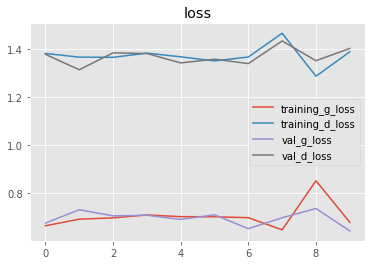

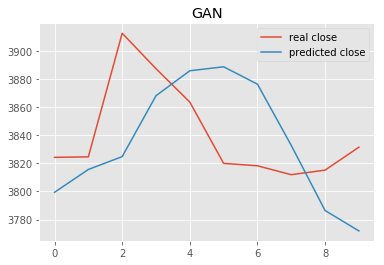

In [17]:
use_gpu = torch.cuda.is_available()
loaders = get_loader(config)

# initial generator and discriminator
# you can try different model type
generator = Generator(model_type='rnn')
discriminator = Discriminator(model_type='rnn')
if use_gpu:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

# the loss is different from before because here we want to do classification 
# whether the generated sequence is real or fake
criterion = nn.BCEWithLogitsLoss()
optimizer_g = optim.Adam(generator.parameters(),
                         lr=config.lr,
                         weight_decay=5e-7)
optimizer_d = optim.Adam(discriminator.parameters(),
                         lr=config.lr,
                         weight_decay=5e-7)

losses = {'train_g': [], 'train_d': [], 'val_g': [], 'val_d': []}
for epoch in range(config.epochs):
    print(f'Epoch: [{epoch}/{config.epochs}]')
    training_size, val_size = 0, 0
    training_g_loss, val_g_loss = 0, 0
    training_d_loss, val_d_loss = 0, 0

    generator.train()
    discriminator.train()
    for i, (inputs, labels) in enumerate(loaders['train']):
        inputs, labels = inputs.float(), labels.float()
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        fakes = generator(inputs)
        
        # generator tries to make the generated sequence real in discriminator
        output_g = discriminator(
            torch.cat([inputs[:, :, 3], fakes], dim=1).unsqueeze(2))
        # so the label should be 1
        loss_g = criterion(output_g, torch.ones_like(output_g))

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # however, the discriminator tries to make the generated sequence by generator to be fake
        # while the true sequence to be real
        output_real = discriminator(
            torch.cat([inputs[:, :, 3], labels.unsqueeze(1)],
                      dim=1).unsqueeze(2))
        output_fake = discriminator(
            torch.cat([inputs[:, :, 3], fakes.detach()], dim=1).unsqueeze(2))
        
        # real sequence should be real, so the label is 1
        loss_d_real = criterion(output_real, torch.ones_like(output_real))
        # generated seq should be fake, so the label is 0
        loss_d_fake = criterion(output_fake, torch.zeros_like(output_fake))
        loss_d = loss_d_real + loss_d_fake

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        training_size += inputs.size()[0]
        training_g_loss = training_g_loss + loss_g.item() * inputs.size()[0]
        training_d_loss = training_d_loss + loss_d.item() * inputs.size()[0]

        if i % 80 == 0:
            print(
                f"iters: [{i}/{len(loaders['train'])}], training_g_loss: {training_g_loss/training_size:.4f} "
                f"training_d_loss: {training_d_loss/training_size:.4f}")

    losses['train_g'].append(training_g_loss / training_size)
    losses['train_d'].append(training_d_loss / training_size)

    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders['val']):
            inputs, labels = inputs.float(), labels.float()
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            fakes = generator(inputs)
            output_g = discriminator(
                torch.cat([inputs[:, :, 3], fakes], dim=1).unsqueeze(2))
            loss_g = criterion(output_g, torch.ones_like(output_g))

            output_real = discriminator(
                torch.cat(
                    [inputs[:, :, 3], labels.unsqueeze(1)],
                    dim=1).unsqueeze(2))
            output_fake = discriminator(
                torch.cat([inputs[:, :, 3], fakes.detach()],
                          dim=1).unsqueeze(2))
            loss_d_real = criterion(output_real, torch.ones_like(output_real))
            loss_d_fake = criterion(output_fake, torch.zeros_like(output_fake))
            loss_d = loss_d_real + loss_d_fake

            val_size += inputs.size()[0]
            val_g_loss = val_g_loss + loss_g.item() * inputs.size()[0]
            val_d_loss = val_d_loss + loss_d.item() * inputs.size()[0]

        losses['val_g'].append(val_g_loss / val_size)
        losses['val_d'].append(val_d_loss / val_size)
        print(
            f"val_g_loss: {val_g_loss/val_size:.4f} val_d_loss: {val_d_loss/val_size:.4f}"
        )

plt.title('loss')
plt.plot(losses['train_g'], label='training_g_loss')
plt.plot(losses['train_d'], label='training_d_loss')
plt.plot(losses['val_g'], label='val_g_loss')
plt.plot(losses['val_d'], label='val_d_loss')
plt.legend()
plt.show()

close_real = []
close_predict = []
for i in range(10):
    val_input, label = val_dataset[i]
    close_real.append(label * (val_dataset.std + 1e-8) + val_dataset.mean)
    val_input = torch.tensor(val_input).float().unsqueeze(0)
    if use_gpu:
        val_input = val_input.cuda()
    val_output = generator(val_input)
    close_predict.append(val_output.item() * (val_dataset.std + 1e-8) +
                         val_dataset.mean)

plt.title('GAN')
plt.plot(close_real, label='real close')
plt.plot(close_predict, label='predicted close')
plt.legend()
plt.show()

## <font color=red>Further Improvement</font>
<font color=red>You can refer this [GAN Tricks](https://github.com/soumith/ganhacks)</font>

# Thrid Part

## <font color=red>Reinforcement Learning</font>
* Deep QLearning
* <font color=red>Policy Gradient</font>
* DDPG
* A3C

![](https://drive.google.com/uc?id=1lcj8jH1xEoYV_yGGH7sa2FXRQO5XvONU)

In [18]:
class net(nn.Module):
    def __init__(self, input_size, output_size):
        super(net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)
        self.fc21 = nn.Linear(10, 1)

    def forward(self, s):
        if len(s.size()) == 1:
            s = s.unsqueeze(0)
        s = self.fc1(s)
        s = F.relu(s, inplace=True)
        logits = self.fc2(s)
        values = self.fc21(s)
        return logits, values

class RL_pg:
    def __init__(self, n_actions, observation_shape, lr=0.01, reward_decay=0.9):
        self.n_actions = n_actions
        self.observation_shape = observation_shape
        self.lr = lr
        self.gama = reward_decay

        self.s = []
        self.a = []
        self.r = []
        self.p = []
        self.v = []

        self.eval = net(self.observation_shape, self.n_actions)
        
        if torch.cuda.is_available():
            self.eval=self.eval.cuda()

    def store_transition(self, s, a, r):
        # store the states for further learning
        self.s.append(s)
        self.a.append(a)
        self.r.append(r)

    def choose_action(self, s):
        # choose action based on the state
        s = torch.tensor(s).float()
        if torch.cuda.is_available():
            s=s.cuda()

        p, v = self.eval.forward(s)
        self.p.append(F.softmax(p, -1))
        self.v.append(v)
        prob_actions = self.p[-1].cpu().data.numpy()
        action = np.random.choice(prob_actions.shape[1], p=prob_actions.reshape(-1, ))
        return action

    def learn(self):
        # before learning, the reward should be normalized
        normed_r = self.norm_reward()

        normed_r = torch.FloatTensor(normed_r)

        optimizer = optim.Adam(self.eval.parameters(), lr=self.lr)

        m = Categorical(torch.cat(self.p))
        a = torch.tensor(self.a).long()
        v = torch.tensor(self.v)
        
        if torch.cuda.is_available():
            a=a.cuda()
            v=v.cuda()
            normed_r=normed_r.cuda()
        
        # policy gradient loss
        loss = torch.mean(torch.mul(-m.log_prob(a), normed_r - v.data)) + \
               F.smooth_l1_loss(v, normed_r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # after learning, we should set the transition to empty for future learning
        self.s = []
        self.a = []
        self.r = []
        self.p = []
        self.v = []
        return normed_r.cpu().data.numpy()

    def norm_reward(self):
        normed_r = np.zeros_like(self.r)

        add = 0
        for i in reversed(range(0, len(self.r))):
            add = add * self.gama + self.r[i]
            normed_r[i] = add

        normed_r -= np.mean(normed_r)
        normed_r = normed_r / np.std(normed_r) if np.std(normed_r) != 0 else normed_r

        return normed_r

    100% |████████████████████████████████| 1.5MB 6.7MB/s eta 0:00:01
    100% |████████████████████████████████| 1.0MB 8.4MB/s eta 0:00:01
    100% |████████████████████████████████| 829kB 8.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for gym ... done
  Stored in directory: /home/yhuangcc/.cache/pip/wheels/57/b0/13/4153e1acab826fbe612c95b1336a63a3fa6416902a8d74a1b7
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/yhuangcc/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built gym future
episode: 0,  reward: 21.0,  running_reward: 0.21
episode: 1,  reward: 13.0,  running_reward: 0.34
episode: 2,  reward: 18.0,  running_reward: 0.51
episode: 3,  reward: 13.0,  running_reward: 0.64
episode: 4,  reward: 9.0,  running_reward: 0.72
episode: 5,  reward: 11.0,  running_reward: 0.83
episode: 6,  reward: 13.0,  running_reward: 0.95
episode: 7,  reward: 11.0,  running_reward: 1.05
episode: 8,  reward: 14.0,  running_re

episode: 117,  reward: 15.0,  running_reward: 13.53
episode: 118,  reward: 29.0,  running_reward: 13.68
episode: 119,  reward: 22.0,  running_reward: 13.77
episode: 120,  reward: 38.0,  running_reward: 14.01
episode: 121,  reward: 27.0,  running_reward: 14.14
episode: 122,  reward: 14.0,  running_reward: 14.14
episode: 123,  reward: 25.0,  running_reward: 14.25
episode: 124,  reward: 33.0,  running_reward: 14.43
episode: 125,  reward: 36.0,  running_reward: 14.65
episode: 126,  reward: 13.0,  running_reward: 14.63
episode: 127,  reward: 25.0,  running_reward: 14.74
episode: 128,  reward: 33.0,  running_reward: 14.92
episode: 129,  reward: 55.0,  running_reward: 15.32
episode: 130,  reward: 26.0,  running_reward: 15.43
episode: 131,  reward: 23.0,  running_reward: 15.50
episode: 132,  reward: 34.0,  running_reward: 15.69
episode: 133,  reward: 25.0,  running_reward: 15.78
episode: 134,  reward: 18.0,  running_reward: 15.80
episode: 135,  reward: 42.0,  running_reward: 16.06
episode: 136

episode: 276,  reward: 169.0,  running_reward: 88.07
episode: 277,  reward: 241.0,  running_reward: 89.60
episode: 278,  reward: 241.0,  running_reward: 91.11
episode: 279,  reward: 231.0,  running_reward: 92.51
episode: 280,  reward: 174.0,  running_reward: 93.33
episode: 281,  reward: 427.0,  running_reward: 96.66
episode: 282,  reward: 119.0,  running_reward: 96.89
episode: 283,  reward: 284.0,  running_reward: 98.76
episode: 284,  reward: 98.0,  running_reward: 98.75
episode: 285,  reward: 424.0,  running_reward: 102.00
episode: 286,  reward: 186.0,  running_reward: 102.84
episode: 287,  reward: 576.0,  running_reward: 107.58
episode: 288,  reward: 183.0,  running_reward: 108.33
episode: 289,  reward: 249.0,  running_reward: 109.74
episode: 290,  reward: 188.0,  running_reward: 110.52
episode: 291,  reward: 272.0,  running_reward: 112.13
episode: 292,  reward: 225.0,  running_reward: 113.26
episode: 293,  reward: 341.0,  running_reward: 115.54
episode: 294,  reward: 230.0,  running

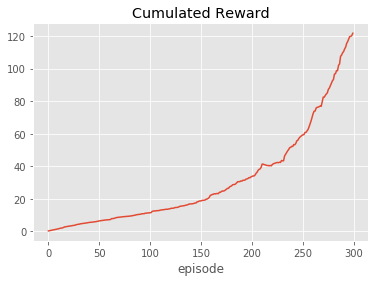

In [19]:
# we use gym for reinforcement learning
try:
    import gym
except:
    ! pip install gym
    import gym

from torch.distributions import Categorical

# use the game cartpole
env = gym.make('CartPole-v0')
env = env.unwrapped

# initial our policy gradient agent
rl_pg = RL_pg(
    n_actions = env.action_space.n,
    observation_shape = env.observation_space.shape[0],
    lr = 0.01,
    reward_decay = 0.99
)

rewards = []
cumulated_reward=0
for i_episode in range(300):

    # reset the env to get the initial observation
    observation = env.reset()

    while True:
        # env.render()
        
        # choose action by agent based on the current observation
        action = rl_pg.choose_action(observation)

        # give the action to env to get the reward and the next observation
        observation_, reward, done, info = env.step(action)

        # store the state
        rl_pg.store_transition(observation, action, reward)

        if done:
            r_sum = sum(rl_pg.r)
            cumulated_reward = cumulated_reward * 0.99 + r_sum * 0.01
            rewards.append(cumulated_reward)

            print(f"episode: {i_episode},  reward: {r_sum},  running_reward: {cumulated_reward:.2f}")
            
            # after the game done, the agent should learn
            vt = rl_pg.learn()
            break

        # set the observation to the new observation
        observation = observation_
        
plt.title('Cumulated Reward')
plt.plot(rewards)
plt.xlabel('episode')
plt.show()